# se detectan vehiculos sin reducir calidad de video y escogiendo un framerate, se almacenan las imagenes en "detected_vehicles_images"


In [ ]:
import cv2
import os
from ultralytics import YOLO
from datetime import datetime

# Cargar el modelo YOLO v11 (usando "yolo11n.pt")
model = YOLO("yolo11n.pt")

# Definir las clases de vehículos (según el mapeo COCO: car=2, motorcycle=3, bus=5, truck=7)
vehicle_class_indices = [2, 3, 5, 7]

# Crear carpeta para guardar las imágenes de vehículos detectados
output_folder = "detected_vehicles_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Definir la ruta del video a procesar y abrirlo
video_path = 'videos/calle1.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error al abrir el video.")
    exit()

# Obtener propiedades iniciales del video
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
print("Video abierto. FPS =", fps, "| Tamaño:", height, "x", width)

frame_count = 0
vehicle_image_count = 0

# Definir el intervalo de frames en el que se usará el modelo (por ejemplo, cada 10 frames)
frame_interval = 10

while True:
    ret, frame = cap.read()
    if not ret:
        print("Fin del video.")
        break

    # Corregir la orientación del frame aplicando una rotación
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
    frame_count += 1

    # Procesar solo el frame si se cumple el intervalo deseado
    if frame_count % frame_interval != 0:
        continue

    # Usar el frame original sin reducción de calidad para realizar la detección
    results = model(frame, imgsz=640, stream=False, verbose=False, conf=0.5, classes=vehicle_class_indices)
    
    if results and results[0].boxes is not None:
        # Obtener las detecciones: [x1, y1, x2, y2, confidence, class]
        dets = results[0].boxes.data.cpu().numpy() if hasattr(results[0].boxes.data, "cpu") else results[0].boxes.data
        for det in dets:
            x1, y1, x2, y2, conf, cls = det
            cls = int(cls)
            if cls in vehicle_class_indices:
                # Asegurarse de que las coordenadas sean enteras y estén dentro de la imagen
                x1_orig = max(int(x1), 0)
                y1_orig = max(int(y1), 0)
                x2_orig = min(int(x2), frame.shape[1])
                y2_orig = min(int(y2), frame.shape[0])
                
                # Extraer la región de interés (ROI) del vehículo
                roi = frame[y1_orig:y2_orig, x1_orig:x2_orig]
                
                # Generar un nombre único para la imagen usando la fecha y un contador
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                filename = os.path.join(output_folder, f"vehicle_{timestamp}_{vehicle_image_count}.png")
                cv2.imwrite(filename, roi)
                vehicle_image_count += 1

                # (Opcional) Dibujar un rectángulo en el frame original para visualizar la detección
                cv2.rectangle(frame, (x1_orig, y1_orig), (x2_orig, y2_orig), (0, 255, 0), 4)

cap.release()


Video abierto. FPS = 29.99066484427621 | Tamaño: 1080 x 1920
Fin del video.


## implementacion con deepsort_realtime

In [2]:
import cv2
import os
import numpy as np
from ultralytics import YOLO
from datetime import datetime
from deep_sort_realtime.deepsort_tracker import DeepSort

# Cargar el modelo YOLO (en este ejemplo "yolo11n.pt")
model = YOLO("models/modelo_vista_superior.pt")
# Clases de vehículos (COCO: car=2, motorcycle=3, bus=5, truck=7)
vehicle_class_indices = [2, 3, 5, 7]

# Inicializar DeepSORT
tracker = DeepSort(max_age=30)

# Configurar video de entrada
video_path = 'videos/calle4.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error al abrir el video.")
    exit()

# Propiedades del video
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
print("Video abierto. FPS =", fps, "| Tamaño:", height, "x", width)

# Configurar video de salida (recordar que se rota el frame, por lo que ancho y alto pueden intercambiarse)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (height, width))

frame_count = 0
frame_interval = 1

def get_color(idx):
    """Genera un color único para cada ID (nota: se reinicia la semilla para consistencia)."""
    np.random.seed(idx)
    return tuple(np.random.randint(0, 255, 3).tolist())


def get_color(idx):
    """Genera un color único para cada ID."""
    # Si idx es numérico en forma de string, conviértelo a entero.
    try:
        seed = int(idx)
    except ValueError:
        # Si no se puede convertir directamente, se puede usar hash y reducirlo.
        seed = hash(idx) % (2**32)
    np.random.seed(seed)
    return tuple(np.random.randint(0, 255, 3).tolist())

while True:
    ret, frame = cap.read()
    if not ret:
        print("Fin del video.")
        break

    # Rotar el frame para corregir la orientación
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame_count += 1

    # Procesar el frame según un intervalo (por ejemplo, cada 10 frames)
    if frame_count % frame_interval != 0:
        out.write(frame)
        continue

    # Realizar detección con YOLO en las clases de vehículos
    results = model(frame, imgsz=640, stream=False, verbose=False, conf=0.5, classes=vehicle_class_indices)

    detections_for_tracker = []
    if results and results[0].boxes is not None:
        # Extraer detecciones: [x1, y1, x2, y2, conf, cls]
        dets = results[0].boxes.data.cpu().numpy() if hasattr(results[0].boxes.data, "cpu") else results[0].boxes.data
        for det in dets:
            x1, y1, x2, y2, conf, cls = det
            # Convertir la caja a formato [x, y, ancho, alto]
            x1 = max(int(x1), 0)
            y1 = max(int(y1), 0)
            w = int(x2) - int(x1)
            h = int(y2) - int(y1)
            bbox = [x1, y1, w, h]
            # Se asigna una etiqueta genérica "vehicle"
            detections_for_tracker.append((bbox, conf, "vehicle"))

    # Actualizar el tracker con las detecciones actuales y el frame (opcional para el modelo de features)
    tracks = tracker.update_tracks(detections_for_tracker, frame=frame)

    # Dibujar bounding boxes y asignar un color único por ID
    for track in tracks:
        # Solo consideramos tracks confirmados
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, r, b = track.to_ltrb()  # Coordenadas: left, top, right, bottom
        color = get_color(track_id)
        cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), color, 4)
        cv2.putText(frame, f'ID: {track_id}', (int(l), int(t)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Guardar el frame procesado en el video de salida
    out.write(frame)

cap.release()
out.release()


Video abierto. FPS = 23.976023976023978 | Tamaño: 720 x 1280
Fin del video.


In [7]:
import cv2
import os
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

def process_video(video_path, show_video=False):
    # Cargar modelo
    model = YOLO(MODEL_PATH)
    
    # Inicializar tracker
    tracker = DeepSort(max_age=MAX_TRACK_AGE)
    
    # Abrir video
    cap = cv2.VideoCapture(video_path)
    
    # Configurar video de salida
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (width, height))
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        print(f"Procesando frame {frame_count}", end='\r')
        
        # Detección de vehículos
        results = model(
            frame, 
            conf=CONFIDENCE_THRESHOLD, 
            classes=VEHICLE_CLASSES
        )
        
        # Preparar detecciones para tracking
        detections_for_tracker = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Convertir coordenadas
                x1, y1, x2, y2 = box.xyxy[0]
                conf = box.conf[0]
                
                # Preparar bbox para tracker
                bbox = [int(x1), int(y1), int(x2-x1), int(y2-y1)]
                detections_for_tracker.append((bbox, conf, "vehicle"))
        
        # Actualizar tracks
        tracks = tracker.update_tracks(detections_for_tracker, frame=frame)
        
        # Dibujar tracks
        for track in tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()
            
            # Dibujar bounding box
            cv2.rectangle(
                frame, 
                (int(ltrb[0]), int(ltrb[1])), 
                (int(ltrb[2]), int(ltrb[3])), 
                (0, 255, 0), 
                2
            )
            
            # Añadir ID
            cv2.putText(
                frame, 
                f'ID: {track_id}', 
                (int(ltrb[0]), int(ltrb[1]-10)), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (0, 255, 0), 
                2
            )
        
        # Guardar frame
        out.write(frame)
        
        # Mostrar en ventana (opcional y con manejo de errores)
        if show_video:
            try:
                cv2.imshow('Tracking', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            except Exception as e:
                print(f"Error al mostrar video: {e}")
    
    # Liberar recursos
    cap.release()
    out.release()
    if show_video:
        cv2.destroyAllWindows()
    
    print("\nProcesamiento de video completado.")

# Configuraciones
MODEL_PATH = r"models/modelo_vista_superior.pt"
CONFIDENCE_THRESHOLD = 0.5
MAX_TRACK_AGE = 30
VEHICLE_CLASSES = [2, 3, 5, 7]  # COCO classes

# Uso
video_path = 'videos/calle4.mp4'
process_video(video_path, show_video=False)

INFO:deep_sort_realtime.embedder.embedder_pytorch:MobileNetV2 Embedder for Deep Sort initialised
INFO:deep_sort_realtime.embedder.embedder_pytorch:- gpu enabled: False
INFO:deep_sort_realtime.embedder.embedder_pytorch:- half precision: False
INFO:deep_sort_realtime.embedder.embedder_pytorch:- max batch size: 16
INFO:deep_sort_realtime.embedder.embedder_pytorch:- expects BGR: True
INFO:deep_sort_realtime.deepsort_tracker:DeepSort Tracker initialised
INFO:deep_sort_realtime.deepsort_tracker:- max age: 30
INFO:deep_sort_realtime.deepsort_tracker:- appearance threshold: 0.2
INFO:deep_sort_realtime.deepsort_tracker:- nms threshold: OFF
INFO:deep_sort_realtime.deepsort_tracker:- max num of appearance features: None
INFO:deep_sort_realtime.deepsort_tracker:- overriding track class : No
INFO:deep_sort_realtime.deepsort_tracker:- today given : No
INFO:deep_sort_realtime.deepsort_tracker:- in-build embedder : Yes
INFO:deep_sort_realtime.deepsort_tracker:- polygon detections : No


Procesando frame 1
0: 384x640 (no detections), 163.2ms
Speed: 7.3ms preprocess, 163.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 (no detections), 252.3ms
Speed: 2.5ms preprocess, 252.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 (no detections), 283.1ms
Speed: 4.7ms preprocess, 283.1ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 (no detections), 158.3ms
Speed: 73.4ms preprocess, 158.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 (no detections), 149.0ms
Speed: 4.1ms preprocess, 149.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 6
0: 384x640 (no detections), 142.5ms
Speed: 2.9ms preprocess, 142.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 7
0: 384x640 (no detections), 137.5ms
Speed: 3.7ms preprocess, 1

In [4]:
pip install ultralytics opencv-python deep-sort-realtime

# deteccion en imagenes

In [1]:
import cv2
import os
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

def detect_objects_in_image(model_path, image_path, confidence_threshold=0.5, vehicle_classes=None):
    """
    Detecta objetos en una imagen usando un modelo YOLO
    """
    # Cargar modelo
    model = YOLO(model_path)
    
    # Leer imagen
    image = cv2.imread(image_path)
    
    # Verificar que la imagen se cargó correctamente
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return
    
    # Información de la imagen original
    print(f"Imagen original - Tamaño: {image.shape}")
    
    # Realizar detección con más información de depuración
    try:
        results = model(
            image, 
            conf=confidence_threshold, 
            classes=vehicle_classes,
            verbose=True  # Mostrar información detallada
        )
        
        # Verificar si hay resultados
        if len(results) == 0 or results[0].boxes is None or len(results[0].boxes) == 0:
            print("No se detectaron objetos en la imagen.")
            return
        
        # Dibujar detecciones
        for result in results:
            boxes = result.boxes
            print(f"Número de detecciones: {len(boxes)}")
            
            for box in boxes:
                # Coordenadas de la caja
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                
                # Confianza y clase
                conf = box.conf[0]
                cls = int(box.cls[0])
                
                # Color de la caja (BGR)
                color = (0, 255, 0)  # Verde
                
                # Dibujar rectángulo
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                
                # Añadir etiqueta con clase y confianza
                label = f"Clase {cls}: {conf:.2f}"
                cv2.putText(
                    image, 
                    label, 
                    (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    color, 
                    2
                )
        
        # Crear directorio de salida si no existe
        os.makedirs('output', exist_ok=True)
        
        # Nombre de archivo de salida
        output_filename = os.path.join('output', f'detected_{os.path.basename(image_path)}')
        
        # Guardar imagen con detecciones
        cv2.imwrite(output_filename, image)
        
        print(f"Imagen guardada en: {output_filename}")
        
        # Visualización con matplotlib
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.title('Imagen Original')
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Detecciones')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error durante la detección: {e}")

# Configuraciones
MODEL_PATH = r"models/modelo_vista_superior.pt"  # Ajusta la ruta a tu modelo
IMAGE_PATH = r"imagenes/imagen50.jpg"
CONFIDENCE_THRESHOLD = 0.5
VEHICLE_CLASSES = [2, 3, 5, 7]  # COCO classes (opcional)

# Ejecutar detección
detect_objects_in_image(
    MODEL_PATH, 
    IMAGE_PATH, 
    CONFIDENCE_THRESHOLD, 
    VEHICLE_CLASSES
)

# Información adicional de depuración
print("\nInformación adicional:")
print(f"Modelo: {MODEL_PATH}")
print(f"Imagen: {IMAGE_PATH}")
print(f"Clases a detectar: {VEHICLE_CLASSES}")
print(f"Umbral de confianza: {CONFIDENCE_THRESHOLD}")

Imagen original - Tamaño: (640, 640, 3)

0: 640x640 (no detections), 257.4ms
Speed: 13.6ms preprocess, 257.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
No se detectaron objetos en la imagen.

Información adicional:
Modelo: models/modelo_vista_superior.pt
Imagen: imagenes/imagen50.jpg
Clases a detectar: [2, 3, 5, 7]
Umbral de confianza: 0.5


# deteccion en imagen

In [3]:
import cv2
import numpy as np
from ultralytics import YOLO
import random
import matplotlib.pyplot as plt

def detectar_y_dibujar_vehiculos(model_path, image_path, confidence_threshold=0.70):
    # Cargar modelo
    model = YOLO(model_path)
    
    # Leer imagen
    image = cv2.imread(image_path)
    
    # Realizar detección
    results = model(image, conf=confidence_threshold)
    
    # Copiar imagen original para dibujar
    image_with_detections = image.copy()
    
    # Función para generar color aleatorio
    def get_random_color():
        return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    # Dibujar detecciones
    for result in results:
        boxes = result.boxes
        
        for box in boxes:
            # Coordenadas de la caja
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            # Confianza y clase
            conf = box.conf[0]
            cls = int(box.cls[0])
            
            # Color aleatorio para cada detección
            color = get_random_color()
            
            # Grosor de línea variable según confianza
            thickness = max(2, int(conf * 5))
            
            # Dibujar rectángulo
            cv2.rectangle(image_with_detections, (x1, y1), (x2, y2), color, thickness)
            
            # Texto con información
            label = f"Vehicle: {conf:.2f}"
            
            # Posición del texto
            (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            
            # Fondo para el texto
            cv2.rectangle(
                image_with_detections, 
                (x1, y1 - label_height - 10), 
                (x1 + label_width, y1), 
                color, 
                -1  # Rectángulo relleno
            )
            
            # Texto
            cv2.putText(
                image_with_detections, 
                label, 
                (x1, y1 - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (255, 255, 255),  # Color del texto
                2
            )
    
    # Guardar imagen con detecciones
    output_path = 'vehiculos_detectados.jpg'
    cv2.imwrite(output_path, image_with_detections)
    
    # Mostrar número de vehículos detectados
    print(f"Vehículos detectados: {len(results[0].boxes)}")
    
    # Visualización con matplotlib
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))
    plt.title(f'Detección de Vehículos (Confianza: {confidence_threshold})')
    plt.axis('off')
    plt.show()
    
    return image_with_detections

# Rutas
MODEL_PATH = r"models/modelo_vista_superior.pt"
IMAGE_PATH = r"imagenes/imagen50.jpg"

# Ejecutar detección
detectar_y_dibujar_vehiculos(MODEL_PATH, IMAGE_PATH)

# Opcional: Probar diferentes umbrales de confianza
detectar_y_dibujar_vehiculos(MODEL_PATH, IMAGE_PATH, confidence_threshold=0.5)


0: 640x640 13 vehicles, 297.3ms
Speed: 9.5ms preprocess, 297.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


: 

# deteccion en video

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import random

def detectar_vehiculos_en_video(model_path, video_path, confidence_threshold=0.70):
    # Cargar modelo
    model = YOLO(model_path)
    
    # Abrir video
    cap = cv2.VideoCapture(video_path)
    
    # Verificar si el video se abrió correctamente
    if not cap.isOpened():
        print("Error al abrir el video")
        return
    
    # Propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Configurar escritura de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_video_detecciones.mp4', fourcc, fps, (width, height))
    
    # Función para generar color aleatorio
    def get_random_color():
        return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    # Contador de frames
    frame_count = 0
    
    while True:
        # Leer frame
        ret, frame = cap.read()
        
        # Verificar si se pudo leer el frame
        if not ret:
            break
        
        # Realizar detección
        results = model(frame, conf=confidence_threshold)
        
        # Copiar frame para dibujar
        frame_with_detections = frame.copy()
        
        # Dibujar detecciones
        for result in results:
            boxes = result.boxes
            
            for box in boxes:
                # Coordenadas de la caja
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                
                # Confianza y clase
                conf = box.conf[0]
                cls = int(box.cls[0])
                
                # Color aleatorio para cada detección
                color = get_random_color()
                
                # Grosor de línea variable según confianza
                thickness = max(2, int(conf * 5))
                
                # Dibujar rectángulo
                cv2.rectangle(frame_with_detections, (x1, y1), (x2, y2), color, thickness)
                
                # Texto con información
                label = f"Vehicle: {conf:.2f}"
                
                # Posición del texto
                (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                
                # Fondo para el texto
                cv2.rectangle(
                    frame_with_detections, 
                    (x1, y1 - label_height - 10), 
                    (x1 + label_width, y1), 
                    color, 
                    -1  # Rectángulo relleno
                )
                
                # Texto
                cv2.putText(
                    frame_with_detections, 
                    label, 
                    (x1, y1 - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (255, 255, 255),  # Color del texto
                    2
                )
        
        # Escribir frame con detecciones
        out.write(frame_with_detections)
        
        # Incrementar contador de frames
        frame_count += 1
        
        # Mostrar progreso
        print(f"Procesando frame {frame_count}", end='\r')
    
    # Liberar recursos
    cap.release()
    out.release()
    
    print(f"\nProcesamiento completado. Total de frames: {frame_count}")
    print("Video de salida: output_video_detecciones.mp4")

# Rutas
MODEL_PATH = r"models/modelo_vista_superior.pt"
VIDEO_PATH = r"videos/calle4.mp4"

# Ejecutar detección en video
detectar_vehiculos_en_video(MODEL_PATH, VIDEO_PATH)

# Opcional: Probar diferentes umbrales de confianza
# detectar_vehiculos_en_video(MODEL_PATH, VIDEO_PATH, confidence_threshold=0.5)


0: 384x640 (no detections), 161.9ms
Speed: 7.8ms preprocess, 161.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 1
0: 384x640 (no detections), 148.5ms
Speed: 6.2ms preprocess, 148.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 (no detections), 130.5ms
Speed: 2.4ms preprocess, 130.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 (no detections), 133.4ms
Speed: 2.2ms preprocess, 133.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 (no detections), 138.1ms
Speed: 3.5ms preprocess, 138.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 (no detections), 139.6ms
Speed: 3.1ms preprocess, 139.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 6
0: 384x640 (no detections), 151.0ms
Speed: 2.7ms preprocess, 151.0ms inference, 0

# uso con deepsort realtime

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import random

def generar_color_unico(track_id):
    """Generar un color consistente para cada track_id"""
    random.seed(track_id)
    return (random.randint(50, 200), random.randint(50, 200), random.randint(50, 200))

def tracking_vehiculos_video(model_path, video_path, confidence_threshold=0.70):
    # Cargar modelo YOLO
    model = YOLO(model_path)
    
    # Inicializar DeepSORT tracker
    tracker = DeepSort(max_age=30)
    
    # Abrir video
    cap = cv2.VideoCapture(video_path)
    
    # Verificar si el video se abrió correctamente
    if not cap.isOpened():
        print("Error al abrir el video")
        return
    
    # Propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Configurar escritura de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_video_tracking.mp4', fourcc, fps, (width, height))
    
    # Contadores y estadísticas
    frame_count = 0
    track_colors = {}  # Diccionario para mantener colores de tracks
    
    while True:
        # Leer frame
        ret, frame = cap.read()
        
        # Verificar si se pudo leer el frame
        if not ret:
            break
        
        # Realizar detección con YOLO
        results = model(frame, conf=confidence_threshold)
        
        # Preparar detecciones para tracker
        detections_for_tracker = []
        
        for result in results:
            boxes = result.boxes
            
            for box in boxes:
                # Coordenadas de la caja
                x1, y1, x2, y2 = box.xyxy[0]
                
                # Convertir a formato [x, y, ancho, alto]
                bbox = [
                    int(x1), 
                    int(y1), 
                    int(x2 - x1),  # ancho
                    int(y2 - y1)   # alto
                ]
                
                # Confianza
                conf = box.conf[0]
                
                # Añadir detección para tracking
                detections_for_tracker.append((bbox, conf, "vehicle"))
        
        # Actualizar tracks
        tracks = tracker.update_tracks(detections_for_tracker, frame=frame)
        
        # Copiar frame para dibujar
        frame_with_tracking = frame.copy()
        
        # Dibujar tracks
        for track in tracks:
            # Solo considerar tracks confirmados
            if not track.is_confirmed():
                continue
            
            # Obtener ID de track
            track_id = track.track_id
            
            # Generar color único para cada track
            if track_id not in track_colors:
                track_colors[track_id] = generar_color_unico(track_id)
            
            color = track_colors[track_id]
            
            # Obtener coordenadas del track
            ltrb = track.to_ltrb()
            
            # Dibujar rectángulo
            cv2.rectangle(
                frame_with_tracking, 
                (int(ltrb[0]), int(ltrb[1])), 
                (int(ltrb[2]), int(ltrb[3])), 
                color, 
                2
            )
            
            # Añadir ID de track
            cv2.putText(
                frame_with_tracking, 
                f"ID: {track_id}", 
                (int(ltrb[0]), int(ltrb[1]) - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                color, 
                2
            )
        
        # Escribir frame con tracking
        out.write(frame_with_tracking)
        
        # Incrementar contador de frames
        frame_count += 1
        
        # Mostrar progreso
        print(f"Procesando frame {frame_count}", end='\r')
    
    # Liberar recursos
    cap.release()
    out.release()
    
    print(f"\nProcesamiento completado. Total de frames: {frame_count}")
    print("Video de salida: output_video_tracking.mp4")

# Rutas
MODEL_PATH = r"models/modelo_vista_superior.pt"
VIDEO_PATH = r"videos/calle4.mp4"

# Ejecutar tracking
tracking_vehiculos_video(MODEL_PATH, VIDEO_PATH)


0: 384x640 (no detections), 275.4ms
Speed: 17.6ms preprocess, 275.4ms inference, 19.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 1
0: 384x640 (no detections), 244.8ms
Speed: 3.2ms preprocess, 244.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 (no detections), 277.0ms
Speed: 183.7ms preprocess, 277.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 (no detections), 165.7ms
Speed: 4.1ms preprocess, 165.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 (no detections), 163.6ms
Speed: 2.9ms preprocess, 163.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 (no detections), 147.3ms
Speed: 3.6ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 6
0: 384x640 (no detections), 151.0ms
Speed: 4.1ms preprocess, 151.0ms inferenc

# uso de trazas y estimador de velocidad con deepsort

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import random
import matplotlib.pyplot as plt

class VehicleTracker:
    def __init__(self, max_age=30):
        self.tracker = DeepSort(max_age=max_age)
        self.track_history = {}  # Historial de posiciones por track
        self.track_speeds = {}   # Velocidades de los tracks

    def update(self, frame, detections):
        # Actualizar tracks
        tracks = self.tracker.update_tracks(detections, frame=frame)
        
        # Procesar cada track
        for track in tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            
            # Obtener coordenadas del centro del bounding box
            ltrb = track.to_ltrb()
            center_x = (ltrb[0] + ltrb[2]) / 2
            center_y = (ltrb[1] + ltrb[3]) / 2
            
            # Inicializar historial si es un nuevo track
            if track_id not in self.track_history:
                self.track_history[track_id] = []
                self.track_speeds[track_id] = []
            
            # Agregar posición actual al historial
            self.track_history[track_id].append((int(center_x), int(center_y)))
            
            # Calcular velocidad (si hay al menos 2 puntos)
            if len(self.track_history[track_id]) > 1:
                # Calcular distancia entre los últimos dos puntos
                last_point = self.track_history[track_id][-1]
                prev_point = self.track_history[track_id][-2]
                
                distance = np.sqrt(
                    (last_point[0] - prev_point[0])**2 + 
                    (last_point[1] - prev_point[1])**2
                )
                
                # Agregar velocidad (píxeles por frame)
                self.track_speeds[track_id].append(distance)
        
        return tracks

def tracking_con_trazado(model_path, video_path, confidence_threshold=0.75):
    # Cargar modelo YOLO
    model = YOLO(model_path)
    
    # Inicializar VehicleTracker
    vehicle_tracker = VehicleTracker(max_age=7)
    
    # Abrir video
    cap = cv2.VideoCapture(video_path)
    
    # Verificar si el video se abrió correctamente
    if not cap.isOpened():
        print("Error al abrir el video")
        return
    
    # Propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Configurar escritura de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_video_tracking_trazado.mp4', fourcc, fps, (width, height))
    
    # Colores para tracks
    track_colors = {}
    
    # Función para generar color único
    def get_track_color(track_id):
        if track_id not in track_colors:
            track_colors[track_id] = (
                random.randint(50, 200), 
                random.randint(50, 200), 
                random.randint(50, 200)
            )
        return track_colors[track_id]
    
    # Contadores
    frame_count = 0
    
    while True:
        # Leer frame
        ret, frame = cap.read()
        
        # Verificar si se pudo leer el frame
        if not ret:
            break
        
        # Realizar detección con YOLO
        results = model(frame, conf=confidence_threshold)
        
        # Preparar detecciones para tracker
        detections_for_tracker = []
        
        for result in results:
            boxes = result.boxes
            
            for box in boxes:
                # Coordenadas de la caja
                x1, y1, x2, y2 = box.xyxy[0]
                
                # Convertir a formato [x, y, ancho, alto]
                bbox = [
                    int(x1), 
                    int(y1), 
                    int(x2 - x1),  # ancho
                    int(y2 - y1)   # alto
                ]
                
                # Confianza
                conf = box.conf[0]
                
                # Añadir detección para tracking
                detections_for_tracker.append((bbox, conf, "vehicle"))
        
        # Actualizar tracks y obtener trazado
        tracks = vehicle_tracker.update(frame, detections_for_tracker)
        
        # Copiar frame para dibujar
        frame_with_tracking = frame.copy()
        
        # Dibujar trazados y tracks
        for track_id, history in vehicle_tracker.track_history.items():
            # Color del track
            color = get_track_color(track_id)
            
            # Dibujar trazado
            if len(history) > 1:
                for i in range(1, len(history)):
                    cv2.line(
                        frame_with_tracking, 
                        history[i-1], 
                        history[i], 
                        color, 
                        2
                    )
            
            # Dibujar último punto del track
            if history:
                cv2.circle(
                    frame_with_tracking, 
                    history[-1], 
                    5, 
                    color, 
                    -1
                )
        
        # Dibujar tracks actuales
        for track in tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            color = get_track_color(track_id)
            
            # Obtener coordenadas del track
            ltrb = track.to_ltrb()
            
            # Dibujar rectángulo
            cv2.rectangle(
                frame_with_tracking, 
                (int(ltrb[0]), int(ltrb[1])), 
                (int(ltrb[2]), int(ltrb[3])), 
                color, 
                2
            )
            
            # Calcular velocidad promedio
            if track_id in vehicle_tracker.track_speeds:
                speeds = vehicle_tracker.track_speeds[track_id]
                avg_speed = np.mean(speeds) * fps if speeds else 0
                
                # Mostrar velocidad
                cv2.putText(
                    frame_with_tracking, 
                    f"ID: {track_id} Speed: {avg_speed:.2f} px/s", 
                    (int(ltrb[0]), int(ltrb[1]) - 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    color, 
                    2
                )
        
        # Escribir frame con tracking
        out.write(frame_with_tracking)
        
        # Incrementar contador de frames
        frame_count += 1
        
        # Mostrar progreso
        print(f"Procesando frame {frame_count}", end='\r')
    
    # Liberar recursos
    cap.release()
    out.release()
    
    print(f"\nProcesamiento completado. Total de frames: {frame_count}")
    print("Video de salida: output_video_tracking_trazado.mp4")
    
    # Generar gráfico de trazados
    plt.figure(figsize=(15, 10))
    plt.title("Trazados de Vehículos")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    
    for track_id, history in vehicle_tracker.track_history.items():
        if len(history) > 1:
            x_coords = [p[0] for p in history]
            y_coords = [p[1] for p in history]
            plt.plot(x_coords, y_coords, label=f'Track {track_id}')
    
    plt.legend()
    plt.gca().invert_yaxis()  # Invertir eje Y para coincidir con coordenadas de imagen
    plt.tight_layout()
    plt.savefig('vehicle_tracks.png')
    plt.close()
    
    return vehicle_tracker

# Rutas
MODEL_PATH = r"models/modelo_vista_superior.pt"
VIDEO_PATH = r"videos/calle5.mp4"

# Ejecutar tracking con trazado
tracker = tracking_con_trazado(MODEL_PATH, VIDEO_PATH)


0: 384x640 2 vehicles, 208.4ms
Speed: 11.6ms preprocess, 208.4ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 1
0: 384x640 3 vehicles, 251.1ms
Speed: 11.4ms preprocess, 251.1ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 3 vehicles, 488.8ms
Speed: 46.5ms preprocess, 488.8ms inference, 41.2ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 3 vehicles, 144.7ms
Speed: 4.1ms preprocess, 144.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 3 vehicles, 140.6ms
Speed: 4.3ms preprocess, 140.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 3 vehicles, 142.6ms
Speed: 4.2ms preprocess, 142.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 6
0: 384x640 3 vehicles, 144.5ms
Speed: 4.1ms preprocess, 144.5ms inference, 1.5ms postprocess per image at

: 

# implementacion anterior con optimizacion de resolucion y framerate

In [19]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import random
import matplotlib.pyplot as plt

class VehicleTracker:
    def __init__(self, max_age=7):
        self.tracker = DeepSort(max_age=max_age)
        self.track_history = {}  # Historial de posiciones por track
        self.track_speeds = {}   # Velocidades de los tracks

    def update(self, frame, detections):
        # Actualizar tracks
        tracks = self.tracker.update_tracks(detections, frame=frame)
        
        # Procesar cada track
        for track in tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            
            # Obtener coordenadas del centro del bounding box
            ltrb = track.to_ltrb()
            center_x = (ltrb[0] + ltrb[2]) / 2
            center_y = (ltrb[1] + ltrb[3]) / 2
            
            # Inicializar historial si es un nuevo track
            if track_id not in self.track_history:
                self.track_history[track_id] = []
                self.track_speeds[track_id] = []
            
            # Agregar posición actual al historial
            self.track_history[track_id].append((int(center_x), int(center_y)))
            
            # Calcular velocidad (si hay al menos 2 puntos)
            if len(self.track_history[track_id]) > 1:
                # Calcular distancia entre los últimos dos puntos
                last_point = self.track_history[track_id][-1]
                prev_point = self.track_history[track_id][-2]
                
                distance = np.sqrt(
                    (last_point[0] - prev_point[0])**2 + 
                    (last_point[1] - prev_point[1])**2
                )
                
                # Agregar velocidad (píxeles por frame)
                self.track_speeds[track_id].append(distance)
        
        return tracks

class VideoProcessor:
    def __init__(self, video_path, max_resolution=1280):
        """
        Inicializar procesador de video con optimización de resolución
        
        :param video_path: Ruta del video
        :param max_resolution: Resolución máxima permitida
        """
        self.video_path = video_path
        self.max_resolution = max_resolution
        
        # Abrir video y obtener propiedades
        self.cap = cv2.VideoCapture(video_path)
        
        if not self.cap.isOpened():
            raise ValueError("No se pudo abrir el video")
        
        # Propiedades originales
        self.original_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.original_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.original_fps = self.cap.get(cv2.CAP_PROP_FPS)
        
        # Calcular nueva resolución
        self.new_width, self.new_height = self.calcular_nueva_resolucion()
        
        # Determinar si es necesario reducir FPS
        self.frame_skip = self.calcular_frame_skip()
        
        print(f"Configuración de procesamiento:")
        print(f"Resolución original: {self.original_width}x{self.original_height}")
        print(f"Resolución procesamiento: {self.new_width}x{self.new_height}")
        print(f"FPS original: {self.original_fps}")
        print(f"Frame skip: {self.frame_skip}")
    
    def calcular_nueva_resolucion(self):
        """
        Calcular nueva resolución manteniendo proporción
        """
        # Si la resolución es menor que el máximo, mantener original
        if max(self.original_width, self.original_height) <= self.max_resolution:
            return self.original_width, self.original_height
        
        # Calcular factor de escala
        if self.original_width > self.original_height:
            scale = self.max_resolution / self.original_width
        else:
            scale = self.max_resolution / self.original_height
        
        new_width = int(self.original_width * scale)
        new_height = int(self.original_height * scale)
        
        # Asegurar que sea par (requerido por algunos codecs)
        new_width = new_width if new_width % 2 == 0 else new_width + 1
        new_height = new_height if new_height % 2 == 0 else new_height + 1
        
        return new_width, new_height
    
    def calcular_frame_skip(self):
        """
        Determinar si es necesario reducir FPS
        """
        # Si es mayor a 30 fps, tomar frames intercalados
        if self.original_fps > 35:  # Margen de tolerancia
            return 2  # Tomar cada segundo frame
        return 1  # Procesar todos los frames
    
    def procesar_video(self, model, confidence_threshold=0.5, max_age=3):
        """
        Procesar video con optimizaciones
        
        :param model: Modelo YOLO
        :param confidence_threshold: Umbral de confianza
        :param max_age: Máxima edad de track
        """
        # Inicializar VehicleTracker
        vehicle_tracker = VehicleTracker(max_age=max_age)
        
        # Configurar escritura de video
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(
            'output_video_tracking_optimizado.mp4', 
            fourcc, 
            self.original_fps / self.frame_skip, 
            (self.new_width, self.new_height)
        )
        
        # Colores para tracks
        track_colors = {}
        
        # Función para generar color único
        def get_track_color(track_id):
            if track_id not in track_colors:
                track_colors[track_id] = (
                    random.randint(50, 200), 
                    random.randint(50, 200), 
                    random.randint(50, 200)
                )
            return track_colors[track_id]
        
        # Contadores
        frame_count = 0
        processed_frame_count = 0
        
        while True:
            # Leer frame
            ret, frame = self.cap.read()
            
            # Verificar si se pudo leer el frame
            if not ret:
                break
            
            # Saltar frames si es necesario
            frame_count += 1
            if frame_count % self.frame_skip != 0:
                continue
            
            # Redimensionar frame
            frame_resized = cv2.resize(frame, (self.new_width, self.new_height))
            
            # Realizar detección con YOLO
            results = model(frame_resized, conf=confidence_threshold)
            
            # Preparar detecciones para tracker
            detections_for_tracker = []
            
            for result in results:
                boxes = result.boxes
                
                for box in boxes:
                    # Coordenadas de la caja
                    x1, y1, x2, y2 = box.xyxy[0]
                    
                    # Convertir a formato [x, y, ancho, alto]
                    bbox = [
                        int(x1), 
                        int(y1), 
                        int(x2 - x1),  # ancho
                        int(y2 - y1)   # alto
                    ]
                    
                    # Confianza
                    conf = box.conf[0]
                    
                    # Añadir detección para tracking
                    detections_for_tracker.append((bbox, conf, "vehicle"))
            
            # Actualizar tracks y obtener trazado
            tracks = vehicle_tracker.update(frame_resized, detections_for_tracker)
            
            # Copiar frame para dibujar
            frame_with_tracking = frame_resized.copy()
            
            # Dibujar trazados y tracks
            for track_id, history in vehicle_tracker.track_history.items():
                # Color del track
                color = get_track_color(track_id)
                
                # Dibujar trazado
                if len(history) > 1:
                    for i in range(1, len(history)):
                        cv2.line(
                            frame_with_tracking, 
                            history[i-1], 
                            history[i], 
                            color, 
                            2
                        )
                
                # Dibujar último punto del track
                if history:
                    cv2.circle(
                        frame_with_tracking, 
                        history[-1], 
                        5, 
                        color, 
                        -1
                    )
            
            # Dibujar tracks actuales
            for track in tracks:
                if not track.is_confirmed():
                    continue
                
                track_id = track.track_id
                color = get_track_color(track_id)
                
                # Obtener coordenadas del track
                ltrb = track.to_ltrb()
                
                # Dibujar rectángulo
                cv2.rectangle(
                    frame_with_tracking, 
                    (int(ltrb[0]), int(ltrb[1])), 
                    (int(ltrb[2]), int(ltrb[3])), 
                    color, 
                    2
                )
                
                # Calcular velocidad promedio
                if track_id in vehicle_tracker.track_speeds:
                    speeds = vehicle_tracker.track_speeds[track_id]
                    avg_speed = np.mean(speeds) * (self.original_fps / self.frame_skip) if speeds else 0
                    
                    # Mostrar velocidad
                    cv2.putText(
                        frame_with_tracking, 
                        f"ID: {track_id} Speed: {avg_speed:.2f} px/s", 
                        (int(ltrb[0]), int(ltrb[1]) - 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        color, 
                        2
                    )
            
            # Escribir frame con tracking
            out.write(frame_with_tracking)
            
            # Incrementar contador de frames procesados
            processed_frame_count += 1
            
            # Mostrar progreso
            print(f"Procesando frame {processed_frame_count}", end='\r')
        
        # Liberar recursos
        self.cap.release()
        out.release()
        
        print(f"\nProcesamiento completado.")
        print(f"Frames originales: {frame_count}")
        print(f"Frames procesados: {processed_frame_count}")
        
        return vehicle_tracker

def main():
    # Rutas
    MODEL_PATH = r"models/modelo_vista_superior.pt"
    #MODEL_PATH = r"yolov8n.pt"
    VIDEO_PATH = r"videos/calle4.mp4"
    
    # Cargar modelo
    model = YOLO(MODEL_PATH)
    
    # Inicializar procesador de video
    try:
        video_processor = VideoProcessor(VIDEO_PATH, max_resolution=1280)
        
        # Procesar video
        tracker = video_processor.procesar_video(
            model, 
            confidence_threshold=0.75,
            max_age=7
        )
    
    except Exception as e:
        print(f"Error en procesamiento: {e}")

# Descomentar si se ejecuta como script independiente
if __name__ == "__main__":
    main()

# Para Jupyter Notebook, puedes llamar directamente
main()

Configuración de procesamiento:
Resolución original: 1280x720
Resolución procesamiento: 1280x720
FPS original: 23.976023976023978
Frame skip: 1

0: 384x640 (no detections), 176.0ms
Speed: 5.5ms preprocess, 176.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 1
0: 384x640 (no detections), 146.9ms
Speed: 3.1ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 (no detections), 125.7ms
Speed: 3.1ms preprocess, 125.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 (no detections), 148.6ms
Speed: 2.7ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 (no detections), 133.9ms
Speed: 2.9ms preprocess, 133.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 (no detections), 134.6ms
Speed: 2.3ms preprocess, 134.6ms inference, 0.9ms post

# lo anterior mas analisis de datos

In [10]:

import cv2
import os
from ultralytics import YOLO
from datetime import datetime
import pandas as pd
import random
import matplotlib.pyplot as plt



class VehicleTracker:
    def __init__(self, max_age=7, fps=None):
        self.tracker = DeepSort(max_age=max_age)
        self.track_history = {}  # Historial de posiciones por track
        self.track_speeds = {}   # Velocidades de los tracks
        self.fps = fps  # frames por segundo del video
    
    def update(self, frame, detections):
        # Actualizar tracks
        tracks = self.tracker.update_tracks(detections, frame=frame)
        
        # Procesar cada track
        for track in tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            
            # Obtener coordenadas del centro del bounding box
            ltrb = track.to_ltrb()
            center_x = (ltrb[0] + ltrb[2]) / 2
            center_y = (ltrb[1] + ltrb[3]) / 2
            
            # Inicializar historial si es un nuevo track
            if track_id not in self.track_history:
                self.track_history[track_id] = []
                self.track_speeds[track_id] = []
            
            # Agregar posición actual al historial
            self.track_history[track_id].append((int(center_x), int(center_y)))
            
            # Calcular velocidad (si hay al menos 2 puntos)
            if len(self.track_history[track_id]) > 1:
                # Calcular distancia entre los últimos dos puntos
                last_point = self.track_history[track_id][-1]
                prev_point = self.track_history[track_id][-2]
                
                # Distancia en píxeles
                pixel_distance = np.sqrt(
                    (last_point[0] - prev_point[0])**2 + 
                    (last_point[1] - prev_point[1])**2
                )
                
                # Calcular velocidad en píxeles/segundo
                if self.fps is not None:
                    # Velocidad = distancia / tiempo
                    # Tiempo entre frames = 1/fps
                    speed_pixels_per_second = pixel_distance * self.fps
                    self.track_speeds[track_id].append(speed_pixels_per_second)
                else:
                    # Si no se conoce el FPS, usar distancia por frame
                    self.track_speeds[track_id].append(pixel_distance)
        
        return tracks





class VideoProcessor:
    def __init__(self, video_path, max_resolution=1280):
        """
        Inicializar procesador de video con optimización de resolución
        
        :param video_path: Ruta del video
        :param max_resolution: Resolución máxima permitida
        """
        # Abrir video y obtener propiedades
        self.cap = cv2.VideoCapture(video_path)
        
        if not self.cap.isOpened():
            raise ValueError("No se pudo abrir el video")
        
        # Propiedades originales
        self.original_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.original_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Obtener FPS del video
        self.original_fps = self.cap.get(cv2.CAP_PROP_FPS)
        
        # Calcular nueva resolución
        self.new_width, self.new_height = self.calcular_nueva_resolucion(max_resolution)
        
        # Determinar si es necesario reducir FPS
        self.frame_skip = self.calcular_frame_skip()
        
        print(f"Configuración de procesamiento:")
        print(f"Resolución original: {self.original_width}x{self.original_height}")
        print(f"Resolución procesamiento: {self.new_width}x{self.new_height}")
        print(f"FPS original: {self.original_fps}")
        print(f"Frame skip: {self.frame_skip}")
    
    def calcular_nueva_resolucion(self, max_resolution):
        """
        Calcular nueva resolución manteniendo proporción
        
        :param max_resolution: Resolución máxima permitida
        :return: Tupla con nuevo ancho y alto
        """
        # Si la resolución es menor que el máximo, mantener original
        if max(self.original_width, self.original_height) <= max_resolution:
            return self.original_width, self.original_height
        
        # Calcular factor de escala
        if self.original_width > self.original_height:
            scale = max_resolution / self.original_width
        else:
            scale = max_resolution / self.original_height
        
        new_width = int(self.original_width * scale)
        new_height = int(self.original_height * scale)
        
        # Asegurar que sea par (requerido por algunos codecs)
        new_width = new_width if new_width % 2 == 0 else new_width + 1
        new_height = new_height if new_height % 2 == 0 else new_height + 1
        
        return new_width, new_height
    
    def calcular_frame_skip(self):
        """
        Determinar si es necesario reducir FPS
        
        :return: Número de frames a saltar
        """
        # Si es mayor a 30 fps, tomar frames intercalados
        if self.original_fps > 35:  # Margen de tolerancia
            return 2  # Tomar cada segundo frame
        return 1  # Procesar todos los frames
    
    def procesar_video(self, model, confidence_threshold=0.5, max_age=3):
        """
        Procesar video con optimizaciones
        
        :param model: Modelo YOLO
        :param confidence_threshold: Umbral de confianza
        :param max_age: Máxima edad de track
        :return: Instancia de VehicleTracker
        """
        # Inicializar VehicleTracker con FPS
        vehicle_tracker = VehicleTracker(
            max_age=max_age, 
            fps=self.original_fps
        )
        
        # Configurar escritura de video
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(
            'output_video_tracking_optimizado.mp4', 
            fourcc, 
            self.original_fps / self.frame_skip, 
            (self.new_width, self.new_height)
        )
        
        # Colores para tracks
        track_colors = {}
        
        # Función para generar color único
        def get_track_color(track_id):
            if track_id not in track_colors:
                track_colors[track_id] = (
                    random.randint(50, 200), 
                    random.randint(50, 200), 
                    random.randint(50, 200)
                )
            return track_colors[track_id]
        
        # Contadores
        frame_count = 0
        processed_frame_count = 0
        
        while True:
            # Leer frame
            ret, frame = self.cap.read()
            
            # Verificar si se pudo leer el frame
            if not ret:
                break
            
            # Saltar frames si es necesario
            frame_count += 1
            if frame_count % self.frame_skip != 0:
                continue
            
            # Redimensionar frame
            frame_resized = cv2.resize(frame, (self.new_width, self.new_height))
            
            # Realizar detección con YOLO
            results = model(frame_resized, conf=confidence_threshold)
            
            # Preparar detecciones para tracker
            detections_for_tracker = []
            
            for result in results:
                boxes = result.boxes
                
                for box in boxes:
                    # Coordenadas de la caja
                    x1, y1, x2, y2 = box.xyxy[0]
                    
                    # Convertir a formato [x, y, ancho, alto]
                    bbox = [
                        int(x1), 
                        int(y1), 
                        int(x2 - x1),  # ancho
                        int(y2 - y1)   # alto
                    ]
                    
                    # Confianza
                    conf = box.conf[0]
                    
                    # Añadir detección para tracking
                    detections_for_tracker.append((bbox, conf, "vehicle"))
            
            # Actualizar tracks y obtener trazado
            tracks = vehicle_tracker.update(frame_resized, detections_for_tracker)
            
            # Copiar frame para dibujar
            frame_with_tracking = frame_resized.copy()
            
            # Dibujar trazados y tracks
            for track_id, history in vehicle_tracker.track_history.items():
                # Color del track
                color = get_track_color(track_id)
                
                # Dibujar trazado
                if len(history) > 1:
                    for i in range(1, len(history)):
                        cv2.line(
                            frame_with_tracking, 
                            history[i-1], 
                            history[i], 
                            color, 
                            2
                        )
                
                # Dibujar último punto del track
                if history:
                    cv2.circle(
                        frame_with_tracking, 
                        history[-1], 
                        5, 
                        color, 
                        -1
                    )
            
            # Dibujar tracks actuales
            for track in tracks:
                if not track.is_confirmed():
                    continue
                
                track_id = track.track_id
                color = get_track_color(track_id)
                
                # Obtener coordenadas del track
                ltrb = track.to_ltrb()
                
                # Dibujar rectángulo
                cv2.rectangle(
                    frame_with_tracking, 
                    (int(ltrb[0]), int(ltrb[1])), 
                    (int(ltrb[2]), int(ltrb[3])), 
                    color, 
                    2
                )
                
                # Calcular velocidad promedio
                if track_id in vehicle_tracker.track_speeds:
                    speeds = vehicle_tracker.track_speeds[track_id]
                    avg_speed = np.mean(speeds) * (self.original_fps / self.frame_skip) if speeds else 0
                    
                    # Mostrar velocidad
                    cv2.putText(
                        frame_with_tracking, 
                        f"ID: {track_id} Speed: {avg_speed:.2f} px/s", 
                        (int(ltrb[0]), int(ltrb[1]) - 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        color, 
                        2
                    )
            
            # Escribir frame con tracking
            out.write(frame_with_tracking)
            
            # Incrementar contador de frames procesados
            processed_frame_count += 1
            
            # Mostrar progreso
            print(f"Procesando frame {processed_frame_count}", end='\r')
        
        # Liberar recursos
        self.cap.release()
        out.release()
        
        print(f"\nProcesamiento completado.")
        print(f"Frames originales: {frame_count}")
        print(f"Frames procesados: {processed_frame_count}")
        
        return vehicle_tracker







def crear_mapa_calor_velocidades(output_dir='vehicle_data'):
    """
    Crear mapa de calor de velocidades vehiculares
    
    :param output_dir: Directorio con los datos CSV
    """
    # Leer archivos
    positions_file = os.path.join(output_dir, 'vehicle_positions.csv')
    speeds_file = os.path.join(output_dir, 'vehicle_speeds.csv')
    
    # Cargar datos
    positions_df = pd.read_csv(positions_file)
    speeds_df = pd.read_csv(speeds_file)
    
    # Combinar dataframes
    merged_df = pd.merge(positions_df, speeds_df, on=['Vehicle_ID', 'Frame'])
    
    # Configurar visualización
    plt.figure(figsize=(16, 10))
    
    # Mapa de calor con Seaborn
    heatmap = sns.kdeplot(
        data=merged_df, 
        x='X', 
        y='Y', 
        weights='Speed_Pixels_Per_Second',  # Usar columna de velocidad
        cmap='YlOrRd',  # Colormap de amarillo a rojo
        fill=True,      # Rellenar con densidad
        levels=10,      # Número de niveles de contorno
        alpha=0.7       # Transparencia
    )
    
    plt.title('Mapa de Calor de Velocidades Vehiculares', fontsize=16)
    plt.xlabel('Posición X (Píxeles)', fontsize=12)
    plt.ylabel('Posición Y (Píxeles)', fontsize=12)
    
    # Añadir barra de color
    plt.colorbar(label='Velocidad (Píxeles/Segundo)')
    
    # Guardar figura
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'velocidad_heatmap_kde.png'), dpi=300)
    plt.show()
    
    # Mapa de calor alternativo con histograma
    plt.figure(figsize=(16, 10))
    
    heatmap_hist = sns.histplot(
        data=merged_df, 
        x='X', 
        y='Y', 
        weights='Speed_Pixels_Per_Second',  # Usar columna de velocidad
        cmap='YlOrRd',  # Colormap de amarillo a rojo
        bins=(50, 50),  # Número de bins en X e Y
        cbar=True,
        alpha=0.7
    )
    
    plt.title('Mapa de Calor de Velocidades Vehiculares (Histograma)', fontsize=16)
    plt.xlabel('Posición X (Píxeles)', fontsize=12)
    plt.ylabel('Posición Y (Píxeles)', fontsize=12)
    
    # Guardar figura
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'velocidad_heatmap_hist.png'), dpi=300)
    plt.show()
    
    # Análisis adicional de zonas de alta velocidad
    zona_alta_velocidad = merged_df.groupby(['X', 'Y'])['Speed_Pixels_Per_Second'].mean()
    top_zonas_velocidad = zona_alta_velocidad.nlargest(10)
    
    print("\nTop 10 Zonas de Mayor Velocidad:")
    print(top_zonas_velocidad)
    
    return top_zonas_velocidad

# Modificar la función de análisis para incluir mapa de calor
def analizar_datos_vehiculos(output_dir='vehicle_data'):
    """
    Genera análisis y visualizaciones de los datos de vehículos
    
    :param output_dir: Directorio con los datos CSV
    """
    # Leer archivos
    positions_file = os.path.join(output_dir, 'vehicle_positions.csv')
    speeds_file = os.path.join(output_dir, 'vehicle_speeds.csv')
    
    # Cargar datos
    positions_df = pd.read_csv(positions_file)
    speeds_df = pd.read_csv(speeds_file)
    
    # 1. Gráfico de Velocidades por Vehículo
    plt.figure(figsize=(15, 7))
    for vehicle_id in speeds_df['Vehicle_ID'].unique():
        vehicle_data = speeds_df[speeds_df['Vehicle_ID'] == vehicle_id]
        plt.plot(vehicle_data['Frame'], vehicle_data['Speed_Pixels_Per_Second'], 
                 label=f'Vehículo {vehicle_id}')
    
    plt.title('Velocidades de Vehículos (Píxeles/Segundo)')
    plt.xlabel('Frame')
    plt.ylabel('Velocidad (Píxeles/Segundo)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vehicle_speeds_plot.png'))
    plt.show()
    
    # 2. Estadísticas descriptivas de velocidades
    print("Estadísticas de Velocidades (Píxeles/Segundo):")
    velocidad_stats = speeds_df.groupby('Vehicle_ID')['Speed_Pixels_Per_Second'].agg([
        'mean',    # Velocidad media
        'max',     # Velocidad máxima
        'min',     # Velocidad mínima
        'median',  # Velocidad mediana
        'std'      # Desviación estándar
    ])
    print(velocidad_stats)
    
    # 3. Mapa de calor de velocidades
    top_zonas_velocidad = crear_mapa_calor_velocidades(output_dir)
    
    return velocidad_stats, top_zonas_velocidad

# Modificar la función principal para incluir mapa de calor
def procesar_video_vehiculos(
    video_path, 
    model_path, 
    output_dir='vehicle_data', 
    max_resolution=1280, 
    confidence_threshold=0.75
):
    """
    Función principal para procesar video y analizar vehículos
    
    :param video_path: Ruta del video
    :param model_path: Ruta del modelo YOLO
    :param output_dir: Directorio para guardar datos
    :param max_resolution: Resolución máxima para procesamiento
    :param confidence_threshold: Umbral de confianza para detección
    """
    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Cargar modelo YOLO
    model = YOLO(model_path)
    
    # 2. Inicializar procesador de video
    video_processor = VideoProcessor(video_path, max_resolution=max_resolution)
    
    # 3. Procesar video y obtener tracker
    tracker = video_processor.procesar_video(
        model, 
        confidence_threshold=confidence_threshold,
        max_age=7
    )
    
    # 4. Guardar datos de vehículos
    save_vehicle_data(tracker, output_dir)
    
    # 5. Analizar datos
    stats = analizar_datos_vehiculos(output_dir)
    
    # 6. Analizar zonas de velocidad
    zonas_velocidad = analisis_zonas_velocidad(output_dir)
    
    return tracker, stats, zonas_velocidad














# Función de análisis de datos
def analizar_datos_vehiculos(output_dir='vehicle_data'):
    """
    Genera análisis y visualizaciones de los datos de vehículos
    
    :param output_dir: Directorio con los datos CSV
    """
    # Leer archivos
    positions_file = os.path.join(output_dir, 'vehicle_positions.csv')
    speeds_file = os.path.join(output_dir, 'vehicle_speeds.csv')
    
    # Cargar datos
    positions_df = pd.read_csv(positions_file)
    speeds_df = pd.read_csv(speeds_file)
    
    # Verificar y usar el nombre correcto de la columna de velocidad
    speed_column = [col for col in speeds_df.columns if 'speed' in col.lower()][0]
    
    # 1. Gráfico de Velocidades por Vehículo
    plt.figure(figsize=(15, 7))
    
    for vehicle_id in speeds_df['Vehicle_ID'].unique():
        vehicle_data = speeds_df[speeds_df['Vehicle_ID'] == vehicle_id]
        plt.plot(vehicle_data['Frame'], vehicle_data[speed_column], 
                 label=f'Vehículo {vehicle_id}')
    
    plt.title('Velocidades de Vehículos (Píxeles/Segundo)')
    plt.xlabel('Frame')
    plt.ylabel('Velocidad (Píxeles/Segundo)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vehicle_speeds_plot.png'))
    plt.show()
    
    # 2. Estadísticas descriptivas de velocidades
    print("Estadísticas de Velocidades (Píxeles/Segundo):")
    velocidad_stats = speeds_df.groupby('Vehicle_ID')[speed_column].agg([
        'mean',    # Velocidad media
        'max',     # Velocidad máxima
        'min',     # Velocidad mínima
        'median',  # Velocidad mediana
        'std'      # Desviación estándar
    ])
    print(velocidad_stats)
    
    # 3. Mapa de calor de velocidades - Método de dispersión
    plt.figure(figsize=(16, 10))
    
    # Combinar dataframes
    merged_df = pd.merge(positions_df, speeds_df, on=['Vehicle_ID', 'Frame'])
    
    # Crear mapa de calor con scatter plot
    scatter = plt.scatter(
        merged_df['X'], 
        merged_df['Y'], 
        c=merged_df[speed_column],  # Color basado en velocidad
        cmap='YlOrRd',              # Colormap de amarillo a rojo
        alpha=0.5,                  # Transparencia
        s=10                        # Tamaño de los puntos
    )
    
    plt.title('Mapa de Calor de Velocidades Vehiculares', fontsize=16)
    plt.xlabel('Posición X (Píxeles)', fontsize=12)
    plt.ylabel('Posición Y (Píxeles)', fontsize=12)
    
    # Añadir barra de color
    plt.colorbar(scatter, label='Velocidad (Píxeles/Segundo)')
    
    # Guardar figura
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'velocidad_heatmap_scatter.png'), dpi=300)
    plt.show()
    
    return velocidad_stats

# Función adicional para análisis más detallado de zonas de velocidad
def visualizar_zonas_velocidad(zonas_velocidad):
    """
    Crear visualizaciones detalladas de zonas de velocidad
    
    :param zonas_velocidad: DataFrame con zonas de velocidad
    """
    # 1. Gráfico de barras de velocidad media por zona
    plt.figure(figsize=(15, 6))
    
    # Preparar datos para el gráfico
    top_zonas = zonas_velocidad.head(10)
    
    # Crear etiquetas para las zonas
    zonas_labels = [f'X:{x.left:.0f}-{x.right:.0f}\nY:{y.left:.0f}-{y.right:.0f}' 
                    for x, y in zip(top_zonas['X_bin'], top_zonas['Y_bin'])]
    
    # Gráfico de barras de velocidad media
    plt.subplot(1, 2, 1)
    plt.bar(zonas_labels, top_zonas['mean'], color='skyblue')
    plt.title('Top 10 Zonas - Velocidad Media')
    plt.xlabel('Zona (X, Y)')
    plt.ylabel('Velocidad Media')
    plt.xticks(rotation=45, ha='right')
    
    # Gráfico de barras de número de mediciones
    plt.subplot(1, 2, 2)
    plt.bar(zonas_labels, top_zonas['count'], color='lightgreen')
    plt.title('Top 10 Zonas - Número de Mediciones')
    plt.xlabel('Zona (X, Y)')
    plt.ylabel('Número de Mediciones')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('zonas_velocidad_barras.png')
    plt.show()
    
    # 2. Mapa de calor de velocidades
    plt.figure(figsize=(12, 8))
    
    # Preparar datos para el mapa de calor
    # Convertir los bins a valores numéricos para el heatmap
    zonas_velocidad['X_centro'] = zonas_velocidad['X_bin'].apply(lambda x: x.mid)
    zonas_velocidad['Y_centro'] = zonas_velocidad['Y_bin'].apply(lambda x: x.mid)
    
    # Crear pivot table para el heatmap
    heatmap_data = zonas_velocidad.pivot_table(
        index='Y_centro', 
        columns='X_centro', 
        values='mean', 
        fill_value=0
    )
    
    # Graficar heatmap
    sns.heatmap(
        heatmap_data, 
        cmap='YlOrRd', 
        annot=True,  # Mostrar valores
        fmt='.2f',   # Formato de los números
        cbar_kws={'label': 'Velocidad Media'}
    )
    
    plt.title('Mapa de Calor de Velocidades por Zona')
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.tight_layout()
    plt.savefig('zonas_velocidad_heatmap.png')
    plt.show()
    
    # 3. Gráfico de dispersión con tamaño y color
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(
        zonas_velocidad['X_centro'], 
        zonas_velocidad['Y_centro'], 
        c=zonas_velocidad['mean'],  # Color basado en velocidad media
        s=zonas_velocidad['count'],  # Tamaño basado en número de mediciones
        cmap='YlOrRd',
        alpha=0.7
    )
    
    plt.colorbar(scatter, label='Velocidad Media')
    plt.title('Dispersión de Zonas de Velocidad')
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.tight_layout()
    plt.savefig('zonas_velocidad_scatter.png')
    plt.show()
    
    # Información adicional
    print("\nResumen de Zonas de Velocidad:")
    print(zonas_velocidad[['X_bin', 'Y_bin', 'mean', 'max', 'min', 'count']]
           .sort_values('mean', ascending=False)
           .head(10))

# Ejemplo de uso
def main():
    # Rutas de configuración
    VIDEO_PATH = "videos/calle4.mp4"
    MODEL_PATH = "models/modelo_vista_superior.pt"
    
    # Procesar video
    tracker, stats, zonas_velocidad = procesar_video_vehiculos(
        VIDEO_PATH, 
        MODEL_PATH, 
        confidence_threshold=0.75
    )
    
    # Visualizar zonas de velocidad
    visualizar_zonas_velocidad(zonas_velocidad)
    
    return tracker, stats, zonas_velocidad

Configuración de procesamiento:
Resolución original: 3840x2160
Resolución procesamiento: 1280x720
FPS original: 59.600346564978175
Frame skip: 2

0: 384x640 3 vehicles, 160.0ms
Speed: 5.4ms preprocess, 160.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 1
0: 384x640 2 vehicles, 195.2ms
Speed: 5.0ms preprocess, 195.2ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 2
0: 384x640 3 vehicles, 298.2ms
Speed: 7.5ms preprocess, 298.2ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 3
0: 384x640 3 vehicles, 148.4ms
Speed: 3.0ms preprocess, 148.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 4
0: 384x640 3 vehicles, 137.6ms
Speed: 2.6ms preprocess, 137.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Procesando frame 5
0: 384x640 2 vehicles, 150.7ms
Speed: 2.5ms preprocess, 150.7ms inference, 1.4ms postprocess per image at shape (1

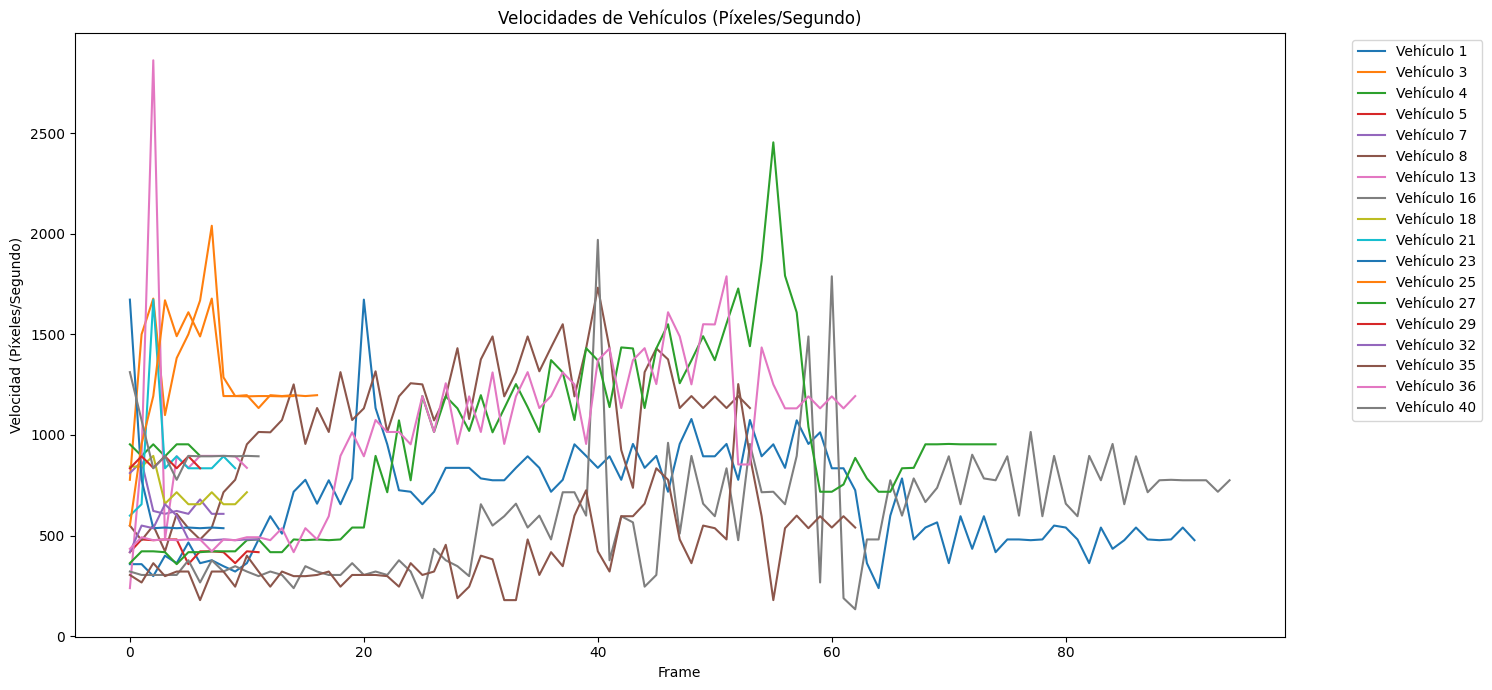

Estadísticas de Velocidades (Píxeles/Segundo):
                   mean          max         min       median         std
Vehicle_ID                                                               
1            676.399793  1673.061455  238.401386   717.683210  244.590337
3           1320.018183  2040.387202  777.093445  1197.952140  287.789178
4            928.629532   953.605545  894.005198   953.605545   31.157583
5            429.533436   480.513356  357.602079   421.438092   43.008409
7            670.412602   867.794145  607.806660   622.245886   99.390774
8           1097.037208  1732.515543  421.438092  1133.973930  312.571144
13           966.113109  2863.298906  238.401386   894.005198  665.457504
16           595.474972  1970.420268  133.270426   596.003466  311.143613
18           728.007010   895.989674  655.603812   715.204159   89.959271
21           888.767599  1673.061455  598.976070   834.404852  292.174366
23           690.542184  1673.061455  536.403119   539.704093  37

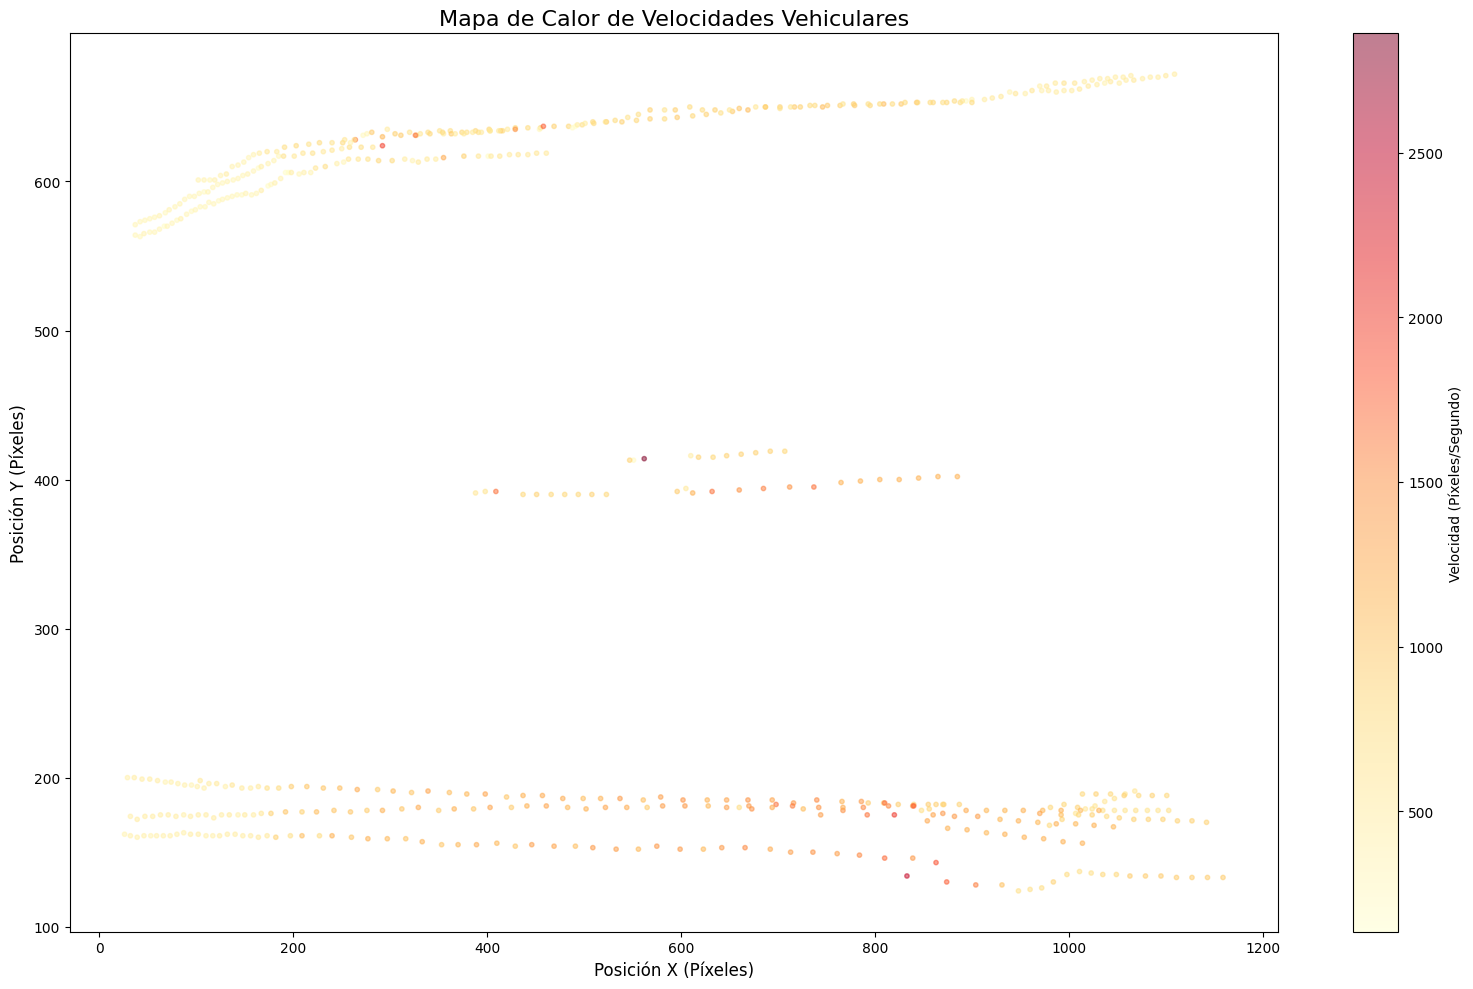

ValueError: too many values to unpack (expected 2)

In [66]:
# Rutas de configuración
VIDEO_PATH = "videos/calle5.mp4"
MODEL_PATH = "models/modelo_vista_superior.pt"
    
# Procesar video
tracker= procesar_video_vehiculos(
    VIDEO_PATH, 
    MODEL_PATH, 
    confidence_threshold=0.75
)

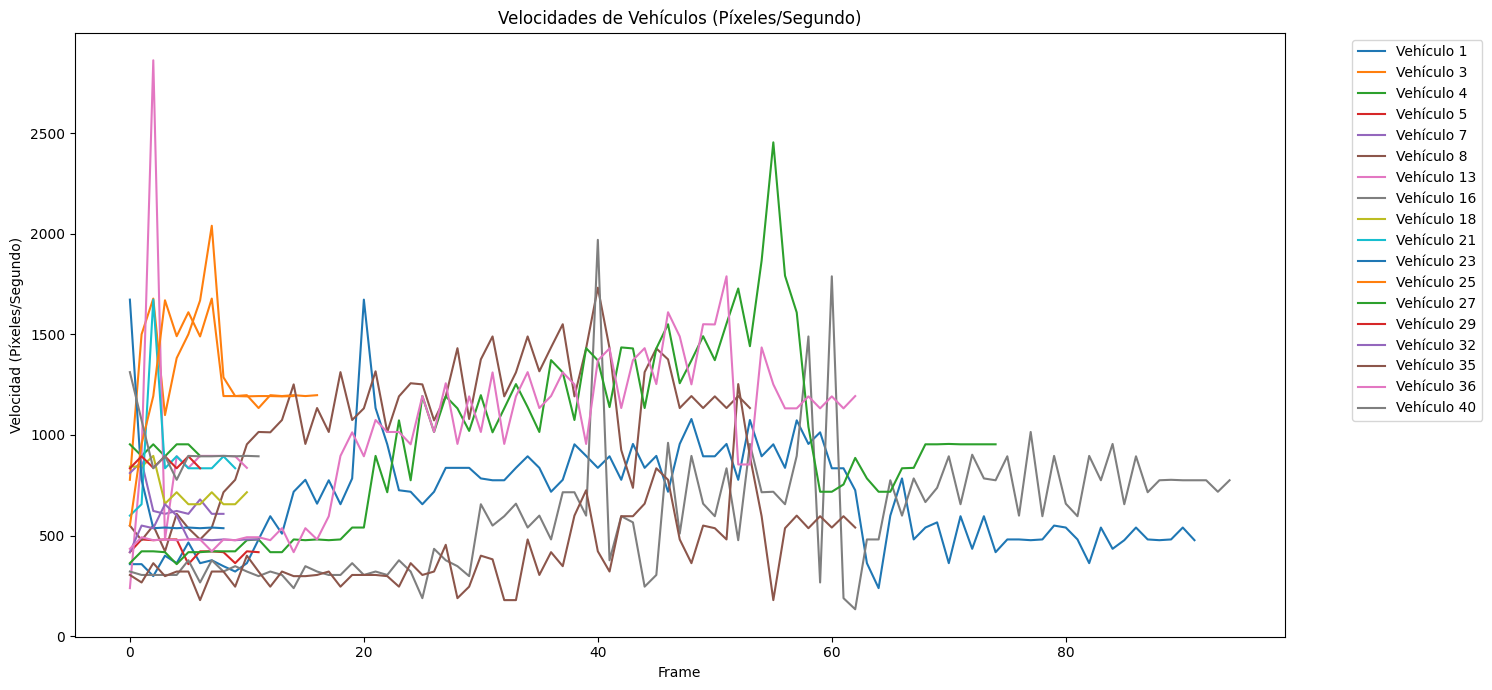

Estadísticas de Velocidades (Píxeles/Segundo):
                   mean          max         min       median         std
Vehicle_ID                                                               
1            676.399793  1673.061455  238.401386   717.683210  244.590337
3           1320.018183  2040.387202  777.093445  1197.952140  287.789178
4            928.629532   953.605545  894.005198   953.605545   31.157583
5            429.533436   480.513356  357.602079   421.438092   43.008409
7            670.412602   867.794145  607.806660   622.245886   99.390774
8           1097.037208  1732.515543  421.438092  1133.973930  312.571144
13           966.113109  2863.298906  238.401386   894.005198  665.457504
16           595.474972  1970.420268  133.270426   596.003466  311.143613
18           728.007010   895.989674  655.603812   715.204159   89.959271
21           888.767599  1673.061455  598.976070   834.404852  292.174366
23           690.542184  1673.061455  536.403119   539.704093  37

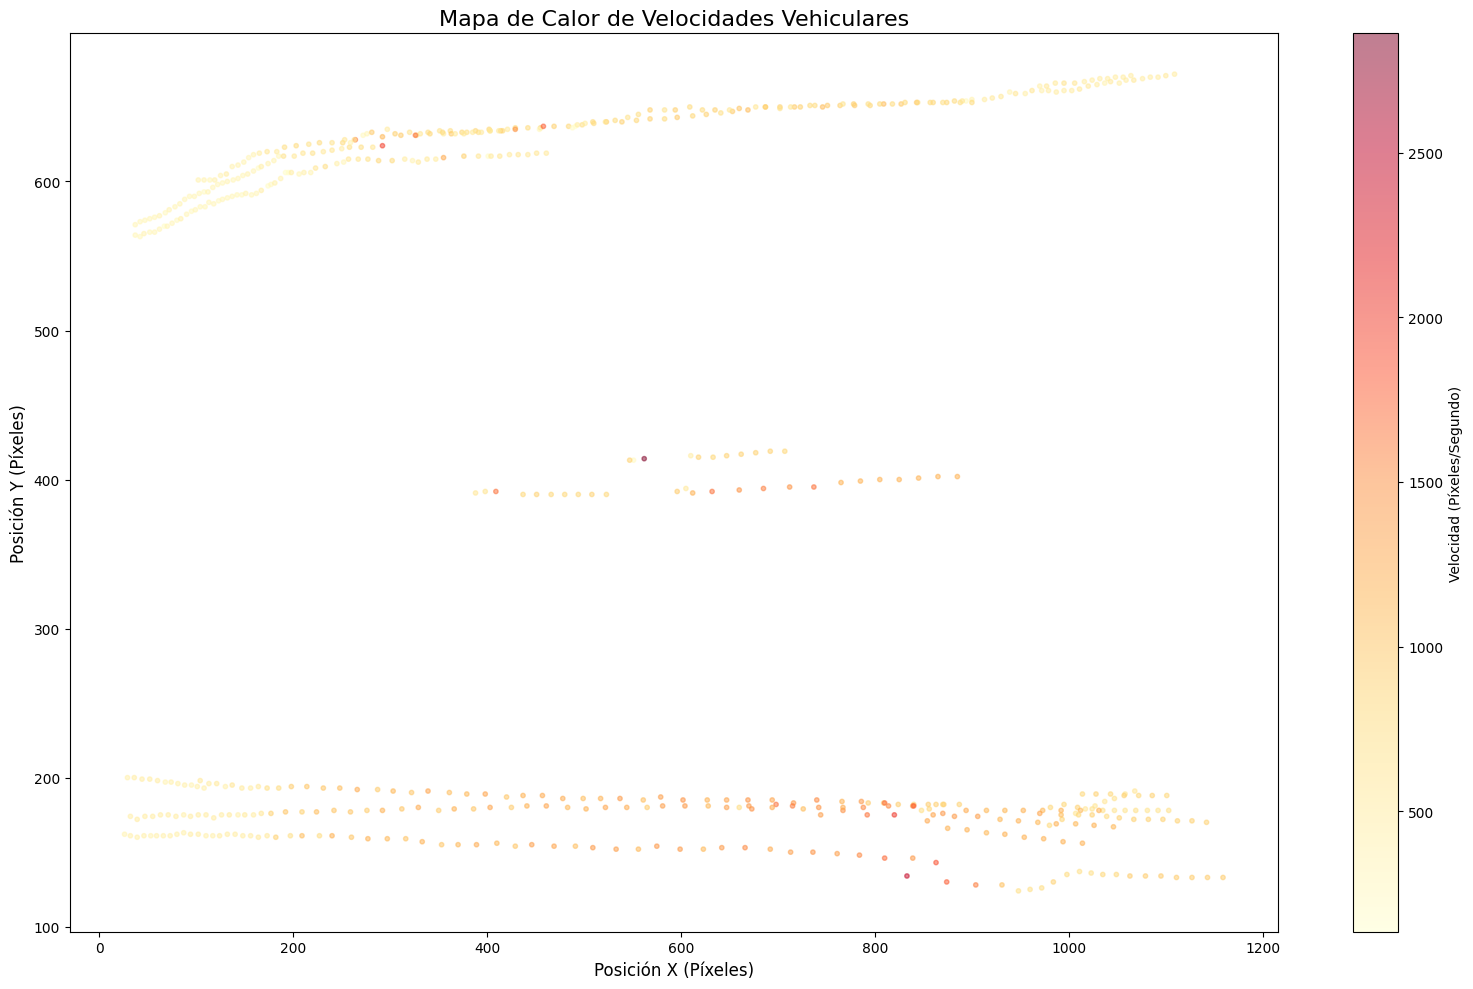

In [11]:
import pandas as pd
stats = analizar_datos_vehiculos("vehicle_data")

Note: you may need to restart the kernel to use updated packages.


# analisis del video